In [405]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops
from transformer_lens.hook_points import HookPoint

In [406]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super(MLP, self).__init__()
        self.w1 = nn.Parameter(torch.ones(hidden_dim, in_dim))
        #self.w2 = nn.Parameter(torch.randn(in_dim, hidden_dim))
        self.b = nn.Parameter(torch.zeros(in_dim))

        self.hook = HookPoint()
    
    def forward(self, x):
        x = F.relu(einops.einsum(self.w1, x, "h i, b i -> b h"))
        x = self.hook(x)
        x = F.relu(einops.einsum(self.w1.T, x, "i h, b h -> b i") + self.b)
        return x

In [407]:
n_features = 100
n_hidden = 40
model = MLP(n_features, n_hidden)
n_sparse = 50
f_sparse = 0
f_dense = 1

In [408]:
# training
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.0001)

batch_size = 10

losses = []

for epoch in range(10000):
    optimizer.zero_grad()
    input = torch.rand(batch_size, n_features)

    input[:, :n_sparse] = 0

    # first 50 features are sparse
    # randomly zero elements 1-f_sparse percent of the time
    input[:, :n_sparse] = input[:, :n_sparse] * (torch.rand(batch_size, n_sparse) < f_sparse).float()

    # last 50 features are dense
    # randomly zero elements 1-f_dense percent of the time
    input[:, n_sparse:] = input[:, n_sparse:] * (torch.rand(batch_size, n_features-n_sparse) < f_dense).float()

    target = torch.abs(input)
    output = model(input)
    loss = F.mse_loss(output, target)
    loss.backward()
    losses.append(loss.item())
    if epoch % 100 == 0:
        print("epoch", epoch, "loss", loss.item())
    optimizer.step()

epoch 0 loss 1089885.25
epoch 100 loss 923672.5
epoch 200 loss 879833.375
epoch 300 loss 911638.0
epoch 400 loss 806224.4375
epoch 500 loss 839479.5
epoch 600 loss 805260.375
epoch 700 loss 769295.625
epoch 800 loss 760410.8125
epoch 900 loss 778100.3125
epoch 1000 loss 633523.5625
epoch 1100 loss 692471.875
epoch 1200 loss 585031.5
epoch 1300 loss 623335.0625
epoch 1400 loss 650392.375
epoch 1500 loss 563867.0
epoch 1600 loss 531847.5
epoch 1700 loss 509765.6875
epoch 1800 loss 500643.53125
epoch 1900 loss 498207.6875
epoch 2000 loss 475569.09375
epoch 2100 loss 437385.3125
epoch 2200 loss 440429.03125
epoch 2300 loss 376832.53125
epoch 2400 loss 427320.4375
epoch 2500 loss 339497.09375
epoch 2600 loss 403683.84375
epoch 2700 loss 375860.25
epoch 2800 loss 362562.25
epoch 2900 loss 332272.75
epoch 3000 loss 286267.4375
epoch 3100 loss 311273.71875
epoch 3200 loss 301877.3125
epoch 3300 loss 270030.34375
epoch 3400 loss 249794.109375
epoch 3500 loss 274374.34375
epoch 3600 loss 230143.

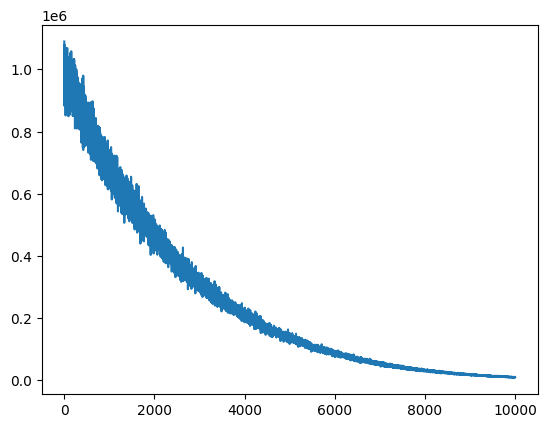

In [409]:
from matplotlib import pyplot as plt

plt.plot(losses)
plt.show()

In [410]:
import numpy as np

In [411]:
def visualize_weights_stacked(w_matrix, cols = None):
    # view the weights as a series of stacked boxes
    np_arr = w_matrix.detach().numpy()
    rows = [np_arr[:, x] for x in range(np_arr.shape[1])]
    col_sums = np.zeros(np_arr.shape[0])
    for i, row in enumerate(rows):
        if cols is not None:
            for n, col in cols:
                if i < n:
                    color = col
                    break
                else:
                    i -= n
        else:
            color = None

        plt.bar(range(np_arr.shape[0]), np.abs(row), bottom=col_sums, linewidth=0.5, edgecolor="white", color=color)
        col_sums += np.abs(row)
    plt.show()

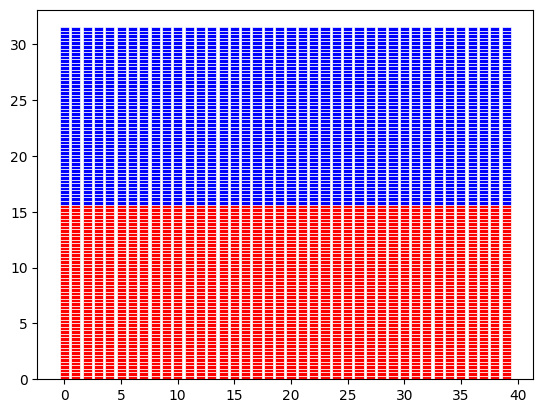

In [412]:
visualize_weights_stacked(model.w1, cols=[(n_sparse, "red"), (n_features-n_sparse, "blue")])
#visualize_weights_stacked(model.w2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


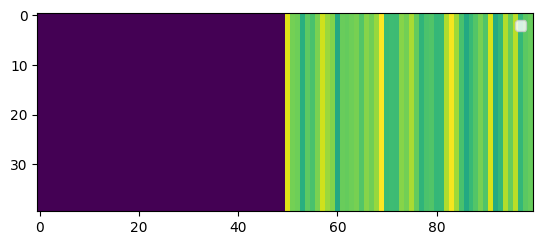

In [415]:
# draw the weights as a heatmap
plt.imshow(model.w1.detach().numpy())
plt.legend()
plt.show()

#plt.imshow(model.w2.detach().numpy())
#plt.show()